In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2 as cv

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Creating list of X and y
X = []
y = []

# Iterate the folder with glob
for fpath in glob.glob('C:/Users/neilr/OneDrive/Documents/BUAS/Year 1/Block C/Creative brief/Data/Resized bannanas/not_spoiled/*.jpeg'):
    # Opening images with OpenCV(Alternatives: PIL, Matplotlib)
    im = cv.imread(fpath, 0)
    #print(fpath)
    im = cv.resize(im, (224, 224))
    label=0
    
    # Put image array to X, put label to y
    X.append(im)
    y.append(label)

for fpath in glob.glob('C:/Users/neilr/OneDrive/Documents/BUAS/Year 1/Block C/Creative brief/Data/Resized bannanas/spoiled/*.jpeg'):
    # Opening images with OpenCV(Alternatives: PIL, Matplotlib)
    
    im=cv.imread(fpath, 0)
    #print(im)
    im = cv.resize(im, (224, 224))
    label=1

    X.append(im)
    y.append(label)
   
# Convert the list of arrays into a numpy array
X = np.array(X)
y = np.array(y)

## 1) The Dataset

**- Assuming you have a classification problem, is it binary, multi-class or multi-label?** 
  
  My model has a binary classification, so my model chooses between 2 classes: spoiled bannana and not spoiled bannana

**- Dataset source(s)?**

- Google images (I used Google image scrapper)
- Imsitu dataset

**- How are the images being labeled?**

The Spoiled Bannana is labeled with 0 and the not spoiled Bannana is labeled with 1.


**Not spoiled Bannana**

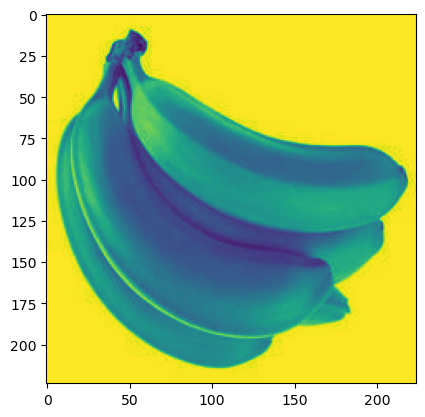

In [3]:
#Not spoiled bannana
plt.imshow(X[1])

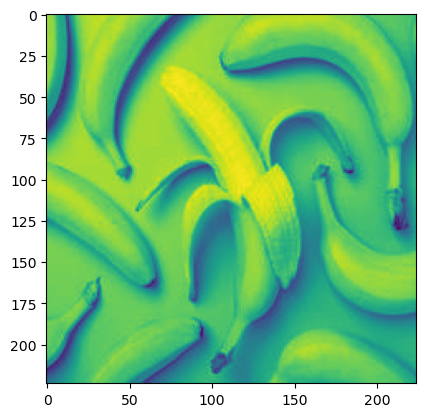

In [4]:
plt.imshow(X[2])

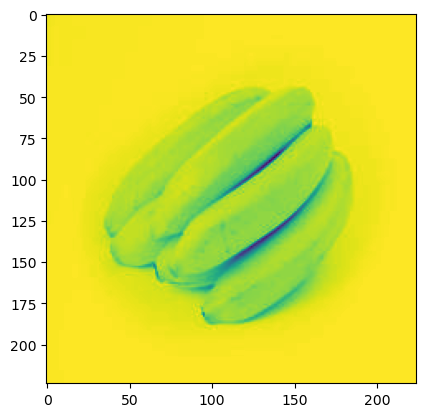

In [5]:
plt.imshow(X[3])

**Spoiled Bannana**

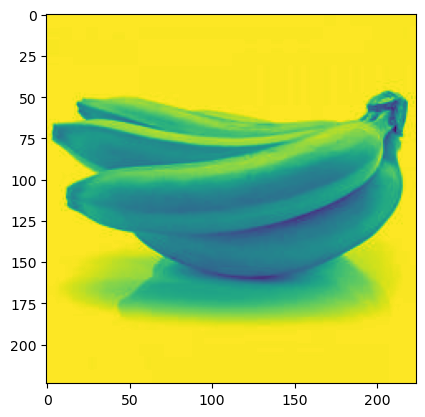

In [6]:
#spoiled bannana
plt.imshow(X[170])

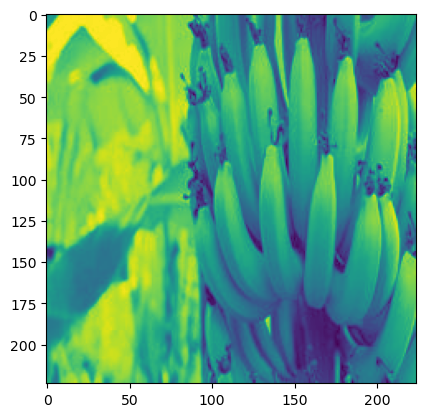

In [7]:
plt.imshow(X[171])

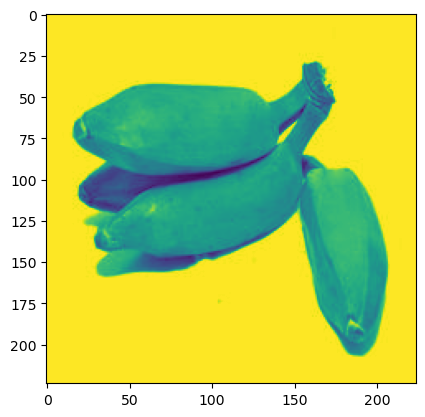

In [8]:
plt.imshow(X[173])

**- How many classes?**

2

**- How many images per class?**

In [9]:
spoiled_bannana = y.sum()
spoiled_bannana

167

In [10]:
bannana= y.__len__()-y.sum()
bannana

213

I have 167 images for spoiled bannana class and I have 213 for my not spoiled bannana class.

**Image size**

My image size is (224,224)


In [11]:
X=X.reshape(-1,224,224,1)

**- Train/ Test size**

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split (X, y, test_size= 0.2, random_state= 13)
X_train, X_val, y_train, y_val = train_test_split (X_train, y_train, test_size= 0.2, random_state= 13)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((243, 224, 224, 1),
 (243,),
 (76, 224, 224, 1),
 (76,),
 (61, 224, 224, 1),
 (61,))

In [14]:
X_train[0].shape

(224, 224, 1)

## 2) Baselines

**- Random guess accuracy:**

The random geus accuracy is 50% because is is a binary classification model ((1/2 = 0.5)*100% = 50%)

**- Human-Level Performance accuracy:** 74.6%

**- Multilayer Perceptron accuracy:** 78.9%

## 3) Preprocessing

**Explain all the preprocessing steps you did.**

1. First resized the image to a fixed size of 224x224, which is a common input size for many image recognition models. 
2. Next, I converted the image to a float between 0 and 1 by dividing each pixel value by 255. 
3. Finally I normalized the pixel values by subtracting the mean RGB values

In [89]:
from PIL import Image
import os

# Define the path to the directory containing the images
image_directory = 'C:/Users/neilr/OneDrive/Documents/BUAS/Year 1/Block C/Creative brief/Data/Resized images/'

# Define the size of the resized images
image_size = (224, 224)

# Loop through all the images in the directory and preprocess each one
for filename in os.listdir(image_directory):
    if filename.endswith('.jpeg'):
        # Open the image file
        image = Image.open(os.path.join(image_directory, filename))

        #Converting images to RGB
        image = image.convert('RGB') # convert to RG

        # Resize the image to a uniform size
        image = image.resize(image_size)

        # Convert the image to a numpy array and normalize the pixel values
        image = np.array(image, dtype=np.float32) / 255.0

        # Save the preprocessed image
        image = Image.fromarray(np.uint8(image * 255.0))
        image.save(os.path.join(image_directory, 'preprocessed', filename))

## 4) CNN architecture

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization

def build_model():
    # Define the CNN architecture
    model = Sequential()

    #   Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [16]:
# Compile the model
from keras.optimizers import Adam
def compile_model(model, lr):
    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

## 5) CNN training

In [17]:
from keras.callbacks import EarlyStopping

#Early stop 
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [18]:
#Train the model
#H = model.fit(train_df, val_df,
                    #epochs=10)
                    #validation_data=(test_df.values))

#Defining the learning rates
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_losses = [] # for plotting best_val_loss vs learning rate

for lr in learning_rates:
    print('Training with: ', lr)
    model = build_model()
    #model.summary
    model = compile_model(model, lr=lr)
    
    # Train the model with early stopping #
    history = model.fit(X_train, y_train,
                         epochs=20,
                           batch_size=32,
                             validation_data=(X_val, y_val),
                               callbacks=[early_stopping])

    best_loss = model.evaluate(X_test, y_test)[0]
    
    best_val_losses.append(best_loss)
    histories.append(history)

Training with:  0.001


c:\Users\neilr\Documents\Anaconda\envs\BlockC\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
8/8 [==============================] - 44s 3s/step - loss: 71.8704 - accuracy: 0.5679 - val_loss: 0.9092 - val_accuracy: 0.5082
Epoch 2/20
8/8 [==============================] - 22s 3s/step - loss: 0.9517 - accuracy: 0.6255 - val_loss: 0.7139 - val_accuracy: 0.5902
Epoch 3/20
8/8 [==============================] - 21s 3s/step - loss: 0.7126 - accuracy: 0.6955 - val_loss: 0.6850 - val_accuracy: 0.6230
Epoch 4/20
8/8 [==============================] - 15s 2s/step - loss: 0.4529 - accuracy: 0.8107 - val_loss: 0.6769 - val_accuracy: 0.6393
Epoch 5/20
8/8 [==============================] - 17s 2s/step - loss: 0.4160 - accuracy: 0.8642 - val_loss: 0.7687 - val_accuracy: 0.6557
Epoch 6/20
3/3 [==============================] - 1s 329ms/step - loss: 3.3756 - accuracy: 0.5789
Training with:  0.0001
Epoch 1/20
8/8 [==============================] - 18s 2s/step - loss: 21.1379 - accuracy: 0.4856 - val_loss: 6.2375 - val_accuracy: 0.5410
Epoch 2/20
8/8 [==============================] -

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)     

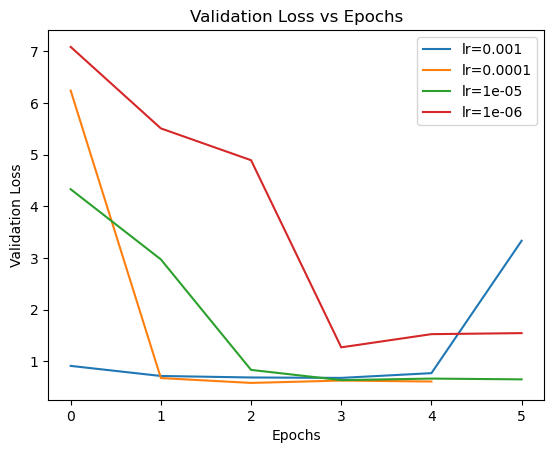

In [20]:
# Plot validation loss vs. epochs for each learning rate 

for i, lr in enumerate(learning_rates):
    val_loss = histories[i].history['val_loss'] 
    plt.plot(val_loss, label=f'lr={lr}')
    

plt.title('Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [21]:
# Evaluate the model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 233ms/step - loss: 1.7058 - accuracy: 0.6316


**Getting more data**

In [22]:
# Creating list of X and y
X2 = []
y2 = []

# Iterate the folder with glob
for fpath in glob.glob('C:/Users/neilr/OneDrive/Documents/BUAS/Year 1/Block C/Creative brief/Data/Resized bannanas/not_spoiled2/*.jpeg'):
    # Opening images with OpenCV
    # Alternatives: PIL, Matplotlib
    im = cv.imread(fpath, 0)
    im = cv.resize(im, (224, 224))
    label=0
    
    # Put image array to X
    # Put label to y
    X2.append(im)
    y2.append(label)

for fpath in glob.glob('C:/Users/neilr/OneDrive/Documents/BUAS/Year 1/Block C/Creative brief/Data/Resized bannanas/spoiled2/*.jpeg'):
    im=cv.imread(fpath, 0)
    im = cv.resize(im, (224, 224))
    label=1

    X2.append(im)
    y2.append(label)
   
        

# Convert the list of arrays
# Into a numpy array
X2 = np.array(X)
y2 = np.array(y)

In [23]:
# Number of images per class
bannana = y2.sum()
bannana

167

In [24]:
# Number of images per class
spoiled_bannana= y2.__len__()-y2.sum()
spoiled_bannana

213

In [25]:
X2=X2.reshape(-1,224,224,1)

In [26]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2  = train_test_split (X2, y2, test_size= 0.2, random_state= 13)
X_train2, X_val2, y_train2, y_val2 = train_test_split (X_train2, y_train2, test_size= 0.2, random_state= 13)

In [27]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape, X_val2.shape, y_val2.shape

((243, 224, 224, 1),
 (243,),
 (76, 224, 224, 1),
 (76,),
 (61, 224, 224, 1),
 (61,))

In [28]:
#Creating a second sequential model
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape= (224,224,1)))
model2.add(BatchNormalization(2))
model2.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model2.add(MaxPooling2D(2))
model2.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [29]:
# Compile the model
from keras.optimizers import Adam
opt = Adam(lr=1e-6)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
from keras.callbacks import EarlyStopping

#Early stop 
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [31]:
# Fit the model on a training set
model2.fit(X_train2, y_train2,
            epochs=20,
                batch_size=32,
                    validation_data=(X_val2, y_val2),
                        callbacks=[early_stopping])

Epoch 1/20
8/8 [==============================] - 119s 13s/step - loss: 0.7682 - accuracy: 0.4403 - val_loss: 1.0900 - val_accuracy: 0.5410
Epoch 2/20
8/8 [==============================] - 111s 14s/step - loss: 0.7080 - accuracy: 0.5761 - val_loss: 0.6749 - val_accuracy: 0.6230
Epoch 3/20
8/8 [==============================] - 92s 12s/step - loss: 0.6703 - accuracy: 0.5720 - val_loss: 0.6790 - val_accuracy: 0.5738
Epoch 4/20
8/8 [==============================] - 91s 12s/step - loss: 0.6767 - accuracy: 0.6132 - val_loss: 0.6659 - val_accuracy: 0.6393
Epoch 5/20
8/8 [==============================] - 95s 12s/step - loss: 0.6830 - accuracy: 0.5761 - val_loss: 0.6600 - val_accuracy: 0.6557
Epoch 6/20
8/8 [==============================] - 93s 11s/step - loss: 0.6885 - accuracy: 0.5679 - val_loss: 0.6575 - val_accuracy: 0.6557
Epoch 7/20
8/8 [==============================] - 87s 11s/step - loss: 0.6741 - accuracy: 0.5844 - val_loss: 0.6518 - val_accuracy: 0.6393
Epoch 8/20
8/8 [=========

In [32]:
# Evaluate the model accuracy on the test set
accuracy2 = model2.evaluate(X_test2, y_test2)

3/3 [==============================] - 3s 917ms/step - loss: 0.6067 - accuracy: 0.7237


In [33]:
#Creating a 3rd sequential model
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape= (224,224,1)))
model3.add(BatchNormalization(2))
model3.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model3.add(MaxPooling2D(2))
model3.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [34]:
# Compile the model
from keras.optimizers import Adam
opt = Adam(lr=1e-6)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
from keras.preprocessing.image import ImageDataGenerator

# Create data generator
data_generator = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate batches of augmented data
data_generator.fit(X_train2)

# Generate augmented images and labels
X_aug, y_aug = next(data_generator.flow(X_train2, y_train2, batch_size=200))

X_train2 = np.concatenate((X, X_aug))
y_train2 = np.concatenate((y, y_aug))

In [36]:
H= model3.fit(X_train2, y_train2, epochs=20, batch_size=32,
           validation_data=(X_val2, y_val2), callbacks=[early_stopping])

Epoch 1/20
19/19 [==============================] - 214s 11s/step - loss: 0.7211 - accuracy: 0.5138 - val_loss: 0.7691 - val_accuracy: 0.5410
Epoch 2/20
19/19 [==============================] - 248s 13s/step - loss: 0.7129 - accuracy: 0.5276 - val_loss: 0.6903 - val_accuracy: 0.5738
Epoch 3/20
19/19 [==============================] - 211s 11s/step - loss: 0.6974 - accuracy: 0.5724 - val_loss: 0.6793 - val_accuracy: 0.6557
Epoch 4/20
19/19 [==============================] - 283s 15s/step - loss: 0.6896 - accuracy: 0.5224 - val_loss: 0.6709 - val_accuracy: 0.6393
Epoch 5/20
19/19 [==============================] - 338s 18s/step - loss: 0.6880 - accuracy: 0.5793 - val_loss: 0.6638 - val_accuracy: 0.5738
Epoch 6/20
19/19 [==============================] - 233s 12s/step - loss: 0.6704 - accuracy: 0.5966 - val_loss: 0.6542 - val_accuracy: 0.6230
Epoch 7/20
19/19 [==============================] - 232s 12s/step - loss: 0.6704 - accuracy: 0.6086 - val_loss: 0.6514 - val_accuracy: 0.6230
Epoch 

In [37]:
# Evaluate the model accuracy on the test set
accuracy3 = model3.evaluate(X_test2, y_test2)

3/3 [==============================] - 4s 1s/step - loss: 0.5398 - accuracy: 0.7895


The accuracy of my model increased after applying data augmentation to my CNN model.

Data augmentation is a technique used to artificially increase the size of a dataset by creating modified version of existing data point. This can be helpful in improving the accuracy of a CNN model, but it can also have the adverse effect of decreasing accuracy if not done correctly. It is possible that the data augmentation may have removed important features from the data which were necessary for accurate predictions. It is also possible that the data augmentation process added noise to the data which adversely affected the model's performance. Either way, it is important to evaluate the data augmentation process to determine the cause of the decrease in accuracy.

## 6) Model performance

Metrics plots

In [38]:
H.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

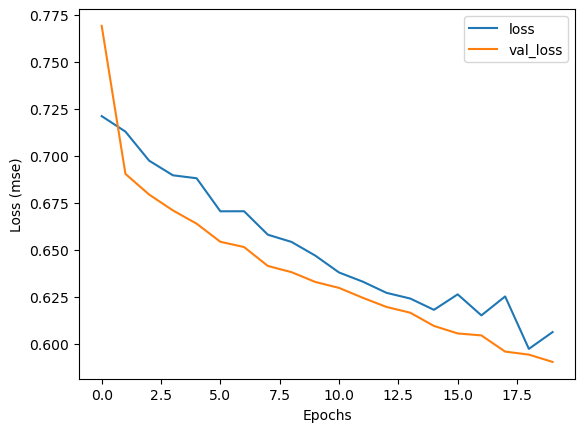

In [39]:
plt.figure(dpi=100)
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.plot(H.history['loss'], label='loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.legend()

(0.0, 1.0)

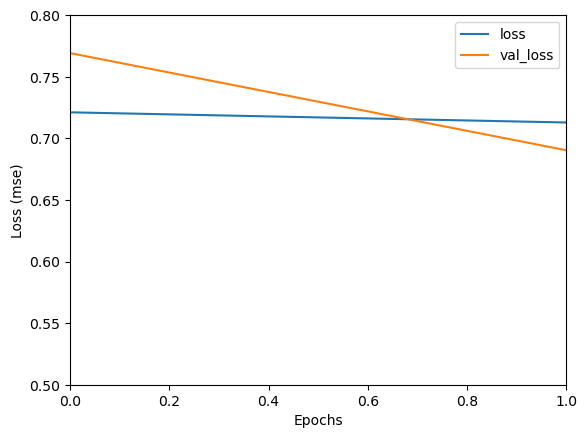

In [98]:
epoch_limits = [0, 1]
loss_limits = [0.5, 0.8]

plt.figure(dpi=100)
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.plot(H.history['loss'], label='loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.legend()

plt.ylim(loss_limits)
plt.xlim(epoch_limits)

(0.0, 1.0)

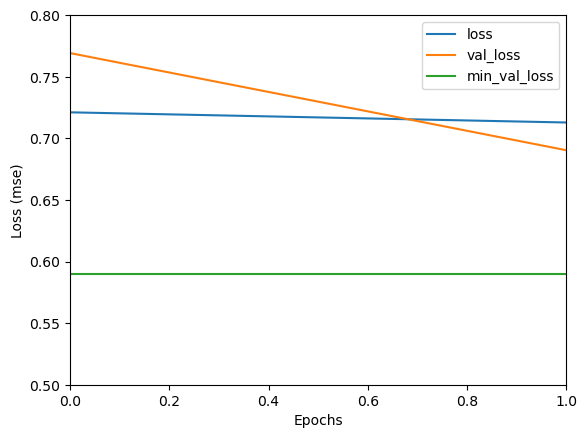

In [99]:
plt.figure(dpi=100)
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.plot(H.history['loss'], label='loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(
    epoch_limits,
    [np.min(H.history['val_loss']), np.min(H.history['val_loss'])],
    label='min_val_loss')
plt.legend()

plt.ylim(loss_limits)
plt.xlim(epoch_limits)

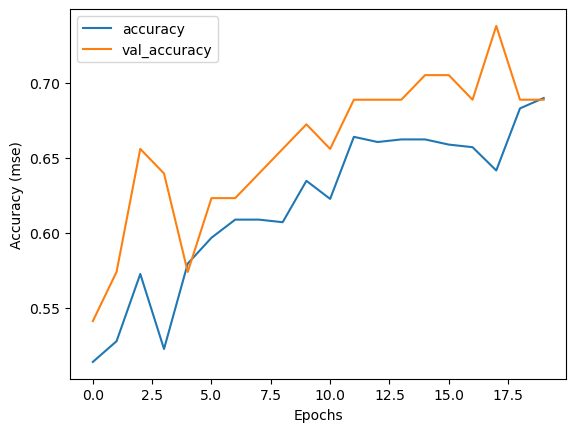

In [100]:
plt.figure(dpi=100)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (mse)')
plt.plot(H.history['accuracy'], label='accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')
plt.legend()

**Classification report**

(A classification report provides a summary of the precision, recall, F1-score, and support for each class in a classification model.)

In [91]:
from sklearn.metrics import classification_report

y_true = y_test2 
y_pred_prob = model.predict(X_test2) 
y_pred = np.argmax(y_pred_prob, axis=1) 

cr = classification_report(y_true, y_pred)

print(cr)

3/3 [==============================] - 2s 689ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        43
           1       0.00      0.00      0.00        33

    accuracy                           0.57        76
   macro avg       0.28      0.50      0.36        76
weighted avg       0.32      0.57      0.41        76



c:\Users\neilr\Documents\Anaconda\envs\BlockC\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neilr\Documents\Anaconda\envs\BlockC\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neilr\Documents\Anaconda\envs\BlockC\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [101]:
"""from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create learning curve
train_sizes, train_scores, val_scores = learning_curve(model, X2, y2, cv=5, scoring='accuracy')

# Calculate mean scores and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1)
plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.legend()
plt.show()"""

"from sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import learning_curve\nimport matplotlib.pyplot as plt\n\n# Create learning curve\ntrain_sizes, train_scores, val_scores = learning_curve(model, X2, y2, cv=5, scoring='accuracy')\n\n# Calculate mean scores and standard deviation\ntrain_scores_mean = np.mean(train_scores, axis=1)\nval_scores_mean = np.mean(val_scores, axis=1)\nval_scores_std = np.std(val_scores, axis=1)\n\n# Plot the learning curve\nplt.plot(train_sizes, train_scores_mean, label='Training score')\nplt.plot(train_sizes, val_scores_mean, label='Validation score')\nplt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1)\nplt.xlabel('Number of training samples')\nplt.ylabel('Score')\nplt.legend()\nplt.show()"

## 7) Error analysis

Top error interpretation

**Confusion Matrix**

(Summarizes the performance of a classification model.)

In [42]:
!pip install seaborn

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

3/3 [==============================] - 3s 366ms/step


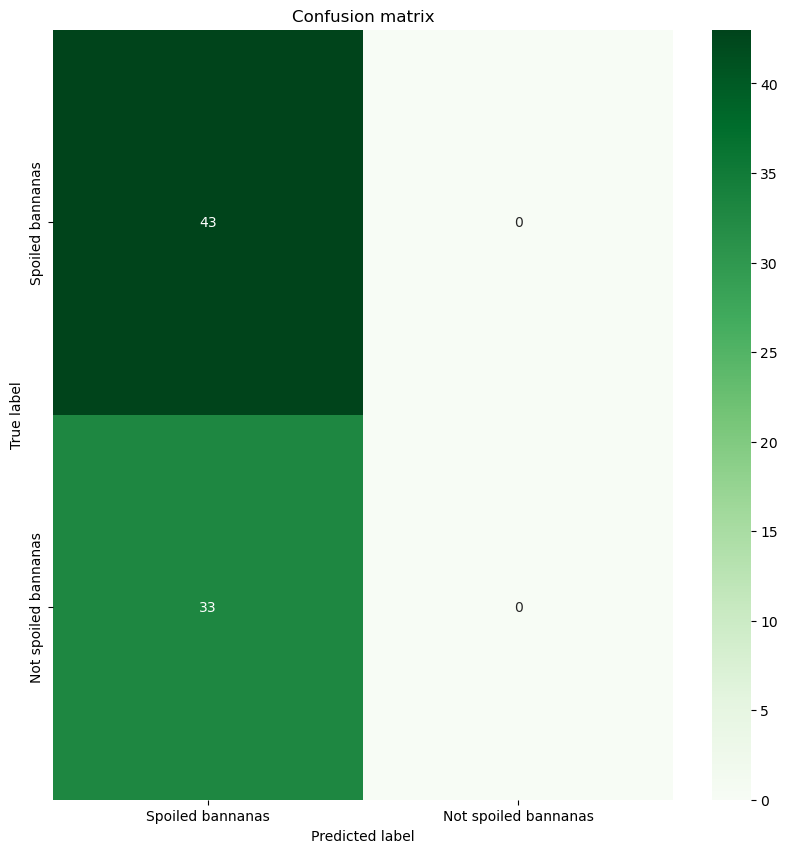

In [44]:
# Store true labels in y_true and predictions in y_pred in order to generate the confusion matrix 
y_true = y_test 
y_pred_prob = model.predict(X_test) 
y_pred = np.argmax(y_pred_prob, axis=1) 

# Create a confusion matrix 
cm = confusion_matrix(y_true, y_pred) 

# Define the classes 
classes = ['Spoiled bannanas', 'Not spoiled bannanas'] 

# Plot the confusion matrix 
plt.figure(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes) 
plt.title('Confusion matrix') 
plt.ylabel('True label') 
plt.xlabel('Predicted label') 
plt.show()

**Mean absolute error**

(The mean absolute error is a measure of the average absolute difference between the predicted and actual values. )

In [63]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)

print(mae)

0.4342105263157895


**Top error analysis**

In [66]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [65]:
# Evaluate the model and get predictions and true labels
X_val = X_test2
y_val = y_test2
y_pred = model3.predict(X_val)

3/3 [==============================] - 10s 2s/step


In [76]:
errors = np.abs(y_val - y_pred)

In [77]:
# Calculate mean error for each sample
mean_errors = np.mean(errors, axis=1)

In [78]:
# Sort errors
sorted_indices = np.argsort(mean_errors)[::-1]
sorted_errors = errors[sorted_indices]
sorted_y_val = y_val[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

In [83]:
# Analyze top errors
top_errors = sorted_errors[:5]
top_y_val = sorted_y_val[:5]
top_y_pred = sorted_y_pred[:5]

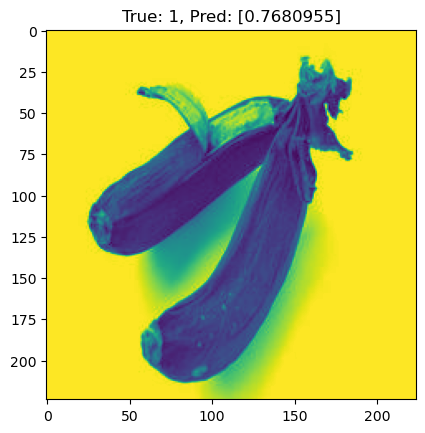

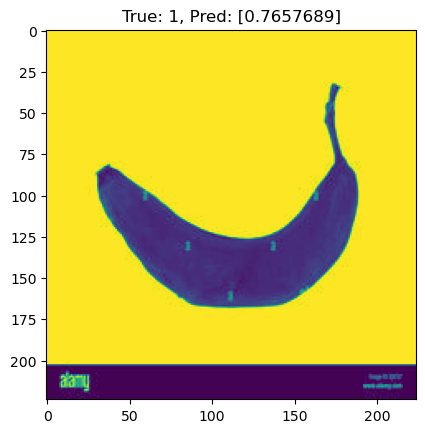

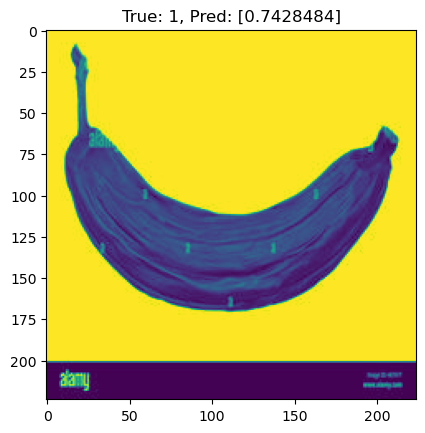

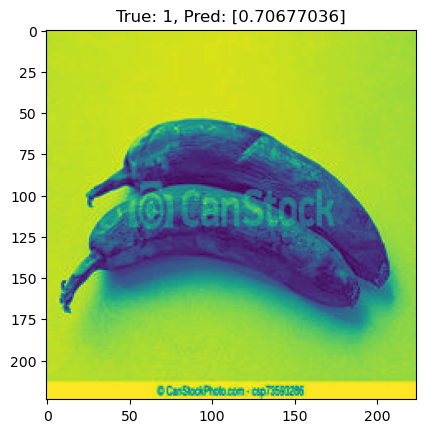

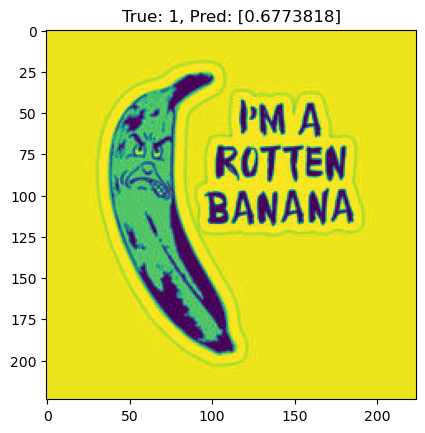

In [103]:
# Visualize top errors
import matplotlib.pyplot as plt
for i in range(len(top_errors)):
    #plt.subplots(5, 3, dpi=300)
    plt.imshow(X_val[sorted_indices[i]])
    plt.title(f'True: {top_y_val[i]}, Pred: {top_y_pred[i]}')
    plt.show()

In [64]:
"""# Define class labels
class_labels= ['Spoiled bannana', 'Not Spoiled Bannana']

# Get the indicies of the misclassified samples
missclassified_indicies = np.where(y_pred != y_true)[0]
missclassified_indicies_sample = missclassified_indicies[:15]

#set the size of the figure and samples
plt.figure(figsize=(10,20))

#Generate and plot the misclassified samples
missclassified_probabilities = []

for i, missclassified_index in enumerate(missclassified_indicies_sample):
    plt.subplots(4, 2)
    plt.imshow(X_test[missclassified_index].reshape(224, 224, 3), cmap= 'gray', interpolation='none')
    predicted_class = class_labels[y_pred[missclassified_index]]
    true_class = class_labels[y_true[missclassified_index]]
    plt.title("Pred: {}, True".format(predicted_class, true_class))
    plt.xticks([])
    plt.yticks([])

#Print the misclassified probabilities
print("Misclassified probabilities")
print(missclassified_probabilities)"""

'# Define class labels\nclass_labels= [\'Spoiled bannana\', \'Not Spoiled Bannana\']\n\n# Get the indicies of the misclassified samples\nmissclassified_indicies = np.where(y_pred != y_true)[0]\nmissclassified_indicies_sample = missclassified_indicies[:15]\n\n#set the size of the figure and samples\nplt.figure(figsize=(10,20))\n\n#Generate and plot the misclassified samples\nmissclassified_probabilities = []\n\nfor i, missclassified_index in enumerate(missclassified_indicies_sample):\n    plt.subplots(4, 2)\n    plt.imshow(X_test[missclassified_index].reshape(224, 224, 3), cmap= \'gray\', interpolation=\'none\')\n    predicted_class = class_labels[y_pred[missclassified_index]]\n    true_class = class_labels[y_true[missclassified_index]]\n    plt.title("Pred: {}, True".format(predicted_class, true_class))\n    plt.xticks([])\n    plt.yticks([])\n\n#Print the misclassified probabilities\nprint("Misclassified probabilities")\nprint(missclassified_probabilities)'